### DB Connection Setup

In [121]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [122]:
engine = create_engine("sqlite:///data_files/hawaii.sqlite")

In [123]:
Base = automap_base()
Base.prepare(autoload_with = engine)
Base.classes.keys()

['measurement', 'station']

In [124]:
Station = Base.classes.station
Measurement = Base.classes.measurement

In [125]:
session = Session(engine)

### EDA of precipitation

In [126]:
# find most recent date in the data set
most_recent_date_str = session.query(Measurement).order_by(Measurement.date.desc()).first().date
most_recent_date = datetime.datetime.strptime(most_recent_date_str, '%Y-%m-%d')
most_recent_date

datetime.datetime(2017, 8, 23, 0, 0)

In [127]:
one_year_ago = (most_recent_date - relativedelta(years=1)) - relativedelta(days=1)
one_year_ago

datetime.datetime(2016, 8, 22, 0, 0)

In [128]:
query_result = session.query(Measurement).filter(Measurement.date > one_year_ago).all()
query_data = [{'Date': x.date, 'Precipitation': x.prcp} for x in query_result]
df = pd.DataFrame(query_data)

In [129]:
df = df.sort_values(by='Date')
df['Date'] = pd.to_datetime(df['Date'])

In [130]:
grouped_df = df[df['Precipitation'] > 0].groupby('Date')['Precipitation'].max().reset_index()


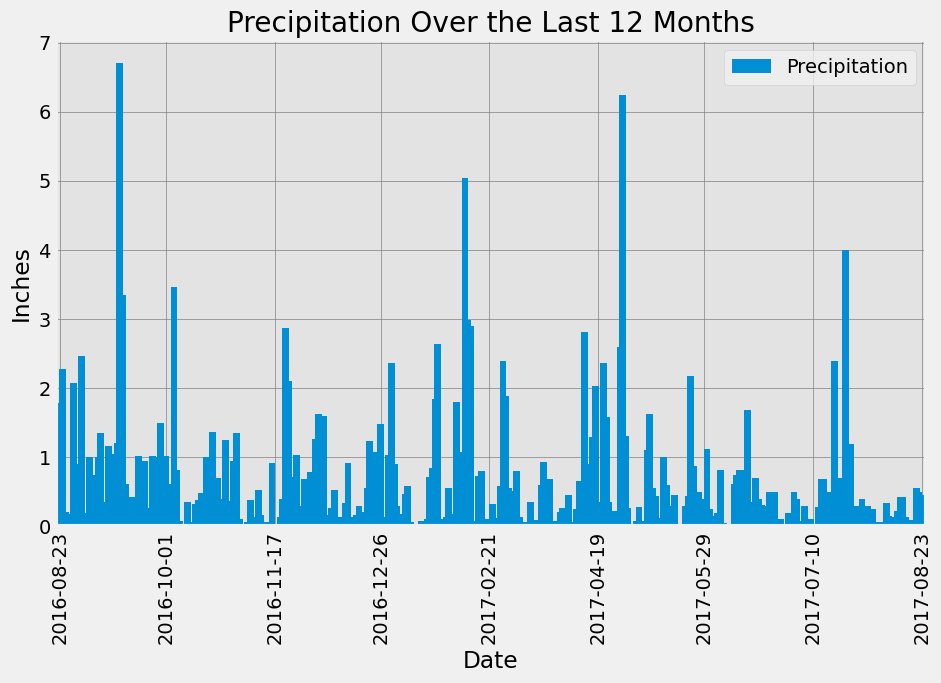

In [131]:
ax = grouped_df.plot(x='Date', y='Precipitation', kind='bar', figsize=(10,6), legend=True, width=2.5)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Over the Last 12 Months')
tick_amount = 9
tick_positions = np.linspace(0,len(grouped_df)-1, tick_amount, dtype=int)
tick_labels = grouped_df['Date'].iloc[tick_positions].dt.strftime('%Y-%m-%d')

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

ax.set_facecolor('#e3e3e3')
ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='gray')
plt.show()


In [132]:
df.describe()[['Precipitation']]

,Precipitation
count,2021.000000
mean,0.177279
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000
std,0.461190


### EDA STATIONS


In [133]:
# Total station count
total_station_count = session.query(Station.station).distinct().count()
total_station_count

9

In [134]:
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [135]:
# Find most active station
most_act_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
most_act_station

'USC00519281'

In [142]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_act_station).all()


[(54.0, 85.0, 71.66378066378067)]

In [137]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_date_for_act_station_str = session.query(Measurement).filter(Measurement.station == most_act_station).order_by(Measurement.date.desc()).first().date
most_recent_date_for_act_station = datetime.datetime.strptime(most_recent_date_for_act_station_str, '%Y-%m-%d')
one_year_ago_most_act = (most_recent_date_for_act_station - relativedelta(years=1)) - relativedelta(days=1)
one_year_ago_most_act

datetime.datetime(2016, 8, 17, 0, 0)

In [138]:
tobs_result = session.query(Measurement).filter(Measurement.station == most_act_station).filter(Measurement.date > one_year_ago_most_act).all()
data_for_df = [{'Date': result.date, 'tobs': result.tobs} for result in tobs_result]
temp_df = pd.DataFrame(data_for_df)


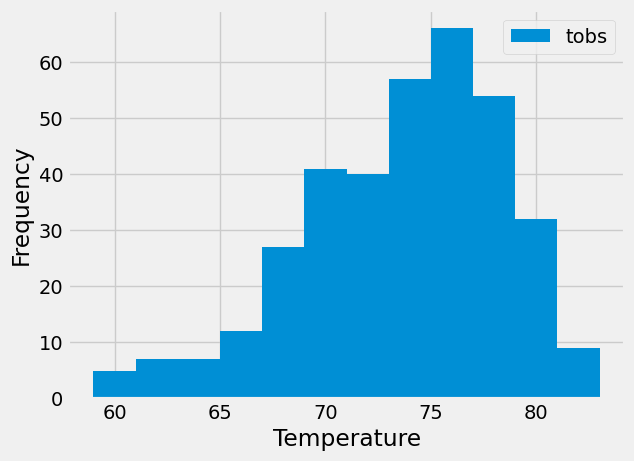

In [139]:
temp_df.hist('tobs', bins=12, legend=True)
plt.title('')
plt.xlabel('Temperature')
plt.ylabel('Frequency')


plt.show()

In [140]:
session.close()